モデルの均衡条件は以下で与えられる(Reifschneider and Williams, 2000)

\begin{align*}
    y_{t} &= E_{t}y_{t+1} - (R_{t}-E_{t}\pi_{t+1}-s_{t}),\\
    \pi_{t} &= \beta E_{t}\pi_{t+1} + \kappa y_{t},\\
    R_{t}^{*} &= r^{*} + \phi_{\pi} E_{t}\pi_{t+1},\\
    R_{t} &= \max \{R_{t}^{*}+m_{t-1} ,0\},\\
    m_{t} &= m_{t-1} - (R_{t}-R_{t}^{*}).
\end{align*}

$(\beta,\kappa,\phi_{\pi},r^{*})$はモデルのパラメータ。定常状態での政策金利は、$r^{*}=(\beta^{-1}-1) \times 100$

$s_t\in\{s_{H},s_{L}\}$は以下の遷移行列を持つマルコフ連鎖にしたがう
\begin{align*}
    P = \left[\begin{array}{cc}
    1-p_{H} & p_{H}\\
    1-p_{L} & p_{L}
    \end{array}\right].
\end{align*}


In [1]:
struct Model{TI<:Integer, TF<:AbstractFloat}
    β::TF       # 割引率
    κ::TF       # フィリップス曲線の傾き
    ϕ::TF       # テイラー係数
    rstar::TF   # pH=0のときの、定常状態での名目金利の値
    sH::TF      # 状態Hでの自然利子率の値
    sL::TF      # 状態Lでの自然利子率の値
    pH::TF      # 危機が起こる確率
    pL::TF      # 危機の継続確率
    maxiter::TI # 繰り返し回数の最大値
    tol::TF     # 許容誤差
end

### アルゴリズム

#### 1. グリッド生成
状態空間の評価点を有限個のグリッドに区切る
  - $(s_{H},s_{L})$はすでに与えられている
  - $m_{-1,j}\in[0,m_{max}]$を$j=1,...,N$個のグリッド$(m_{-1,1},m_{-1,2},...,m_{-1,N})$に分割

#### 2. 収束の基準
収束の基準になるパラメータ$\varepsilon>0$を与える


#### 3. 最適化および補間
古い政策関数

$$
y = \varsigma_{y}^{(n-1)}(m_{-1},s), \quad \pi = \varsigma_{\pi}^{(n-1)}(m_{-1},s)
$$

およびそれぞれのグリッドにおける$(\color{blue}{m_{-1,j},s_{i}})$の値を所与として、以下の式を$(\color{magenta}{y_{i,j},\pi_{i,j},r_{n,i,j},r_{n,i,j}^{*},m_{i,j}})$について解く

\begin{align*}
  \color{magenta}{y_{i,j}} &= y_{i}^{e}(\color{magenta}{m_{i,j}}) - \left(\color{magenta}{r_{n,i,j}}-\pi_{i}^{e}(\color{magenta}{m_{i,j}})-\color{blue}{s_{i}}\right) \\
  \color{magenta}{\pi_{i,j}} &= \kappa \color{magenta}{y_{i,j}} + \beta \pi_{i}^{e}(\color{magenta}{m_{i,j}}) \\
  \color{magenta}{r_{n,i,j}^{*}} &= r^{*} + \phi_{\pi} \pi_{i}^{e}(\color{magenta}{m_{i,j}}) \\
  \color{magenta}{r_{n,i,j}} &= \max\{\color{magenta}{r_{n,i,j}^{*}}-\color{blue}{m_{-1,j}}, 0\} \\
  \color{magenta}{m_{i,j}} &= \color{blue}{m_{-1,j}} + (\color{magenta}{r_{n,i,j}}-\color{magenta}{r_{n,i,j}^{*}})
\end{align*}

ゼロ点を数値的に解く最適化アルゴリズム（ニュートン法など）を用いる

ここで、$y_{i}^{e}(\color{magenta}{m_{i,j}}),\pi_{i}^{e}(\color{magenta}{m_{i,j}})$は$\color{magenta}{m_{i,j}}$の非線形な関数

\begin{align*}
  y_{i}^{e}(\color{magenta}{m_{i,j}}) &= (1-p_{i})\varsigma_{y}^{(n-1)}(\color{magenta}{m_{i,j}},s_{H}) + p_{i}\varsigma_{y}^{(n-1)}(\color{magenta}{m_{i,j}},s_{L}) \\
  \pi_{i}^{e}(\color{magenta}{m_{i,j}}) &= (1-p_{i})\varsigma_{\pi}^{(n-1)}(\color{magenta}{m_{i,j}},s_{H}) + p_{i}\varsigma_{\pi}^{(n-1)}(\color{magenta}{m_{i,j}},s_{L})
\end{align*}

である。$\color{magenta}{m_{i,j}}$はグリッド上にあるとは限らないので、$\varsigma^{(n-1)}(\color{blue}{m_{-1,j},s_{i}})$の値から補間する必要がある

このステップで、新しい政策関数のベクトル$\varsigma^{(n)}(m_{-1,j},s_{i})$

$$
  (y_{H,1}^{(n)},y_{H,2}^{(n)},...,y_{H,N}^{(n)},y_{L,1}^{(n)},y_{L,2}^{(n)},...,,y_{L,N}^{(n)}), \\
  (\pi_{H,1}^{(n)},\pi_{H,2}^{(n)},...,\pi_{H,N}^{(n)},\pi_{L,1}^{(n)},\pi_{L,2}^{(n)},...,,\pi_{L,N}^{(n)}), \\
  (r_{n,H,1}^{(n)},r_{n,H,2}^{(n)},...,r_{n,H,N}^{(n)},r_{n,L,1}^{(n)},r_{n,L,2}^{(n)},...,,r_{n,L,N}^{(n)}), \\
  (r_{n,H,1}^{*(n)},r_{n,H,2}^{*(n)},...,r_{n,H,N}^{*(n)},r_{n,L,1}^{*(n)},r_{n,L,2}^{*(n)},...,,r_{n,L,N}^{*(n)}), \\
  (m_{H,1}^{(n)},m_{H,2}^{(n)},...,m_{H,N}^{(n)},m_{L,1}^{(n)},m_{L,2}^{(n)},...,,m_{L,N}^{(n)})
$$

を得る

#### 4. 収束の判定
全ての$(m_{-1,j},s_{i})$について$\|\varsigma^{(n)}(m_{-1,j},s_{i})-\varsigma^{(n-1)}(m_{-1,j},s_{i})\|<\varepsilon$であればストップ。そうでなければ、$\varsigma^{(n)}(m_{-1,j},s_{i})$を$\varsigma^{(n-1)}(m_{-1,j},s_{i})$に代入して、ステップ3-4を繰り返す

In [2]:
# time iterationを行う関数
function ti(m,mmin,mmax,Ns,N,damp)

    β = m.β
    κ = m.κ
    ϕ = m.ϕ
    rstar = m.rstar
    pH = m.pH
    pL = m.pL
    sH = m.sH
    sL = m.sL

    Gs = [sH; sL]
    Ps = [1.0-pH pH; 1.0-pL pL]

    # mgrid = collect(LinRange(mmin,mmax,N))
    mgrid = range(mmin,stop=mmax,length=N)

    # initial guess for zeta = 0
    # (semi-)analytical
    A = [-1+(1-pH) pH -(ϕ-1)*(1-pH) -(ϕ-1)*pH;
    κ 0 -1+β*(1-pH) β*pH;
    (1-pL) -1+pL (1-pL) pL;
    0 κ β*(1-pL) -1+β*pL]
    b = [rstar-sH;0;-sL;0]
    x = A\b
    yH  = x[1]
    yL  = x[2]
    piH = x[3]
    piL = x[4]
    # check>0
    iH = rstar + ϕ*((1-pH)*piH + pH*piL)
    println(iH)

    ## STEP 1.b: 政策関数の初期値を当て推量
#     Ns = 2
    # 解析的解を初期値とする
    ymat0 = ones(Float64,N,1)*[yH yL]
    pmat0 = ones(Float64,N,1)*[piH piL]
    imat0 = ones(Float64,N,1)*[iH 0]
    # 適当な初期値
    # ymat0 = zeros(Float64,N,Ns)
    # pmat0 = zeros(Float64,N,Ns)
    # imat0 = zeros(Float64,N,Ns)
    mmat0 = zeros(Float64,N,Ns)
    nmat0 = zeros(Float64,N,Ns) # nortional rate

    ymat1 = copy(ymat0)
    pmat1 = copy(pmat0)
    imat1 = copy(imat0)
    mmat1 = copy(mmat0)
    nmat1 = copy(nmat0)

    ## STEP 4: 政策関数を繰り返し計算
    diff = 1e+4
    iter = 0

    while (diff>m.tol && iter<m.maxiter)

        ## STEP 3: 各グリッドごとに最適化
        @inbounds for is in 1:Ns

            # ショックの値
            s0 = Gs[is]

            # 古い政策関数から期待値(ye,pie)を計算
            eyvec = zeros(Float64,N)
            epvec = zeros(Float64,N)

            @inbounds for js in 1:Ns

                eyvec = eyvec + Ps[is,js]*ymat0[:,js]
                epvec = epvec + Ps[is,js]*pmat0[:,js]

            end

            # 期待値はm_{t}の関数：m_{t}は必ずしもグリッド上にあるとは限らないため、補間する
            eyintp = LinearInterpolation(mgrid,eyvec,extrapolation_bc=Line())
            epintp = LinearInterpolation(mgrid,epvec,extrapolation_bc=Line())

            @inbounds for im in 1:N

                mpast = mgrid[im]

                # solve for m0
                res = nlsolve(x->rw_eqm2(x,mpast,epintp,ϕ,rstar),[mpast])
                m0 = res.zero[1]

                ey0 = eyintp(m0)
                ep0 = epintp(m0)
                is0 = rstar + ϕ*ep0
                i0 = max(is0+mpast,0.0)
                y0 = ey0 - (i0 - ep0 - s0)
                p0 = κ*y0 + β*ep0
                if (is0>0.0)
                    m0 = mpast - (i0-is0)
                else
                    m0 = mpast - (0.0-is0)
                end

                # 新しい政策関数を保存
                ymat1[im,is] = y0
                pmat1[im,is] = p0
                imat1[im,is] = i0
                mmat1[im,is] = m0
                nmat1[im,is] = is0

            end

        end

        # 繰り返し計算誤差を確認
        ydiff = maximum(abs.(ymat1-ymat0))
        pdiff = maximum(abs.(pmat1-pmat0))
        diff = maximum([ydiff pdiff])

        println([iter diff])

        # 政策関数をアップデート
        ymat0 = damp*ymat1 + (1.0-damp)*ymat0
        pmat0 = damp*pmat1 + (1.0-damp)*pmat0
        imat0 = damp*imat1 + (1.0-damp)*imat0
        mmat0 = damp*mmat1 + (1.0-damp)*mmat0
        nmat0 = damp*nmat1 + (1.0-damp)*nmat0

        iter = iter + 1

    end

    return ymat0, pmat0, imat0, mmat0, nmat0

end


ti (generic function with 1 method)

In [3]:
function rw_eqm2(x,mpast,epintp,ϕ,rstar)

    m0 = x[1]
    epi = epintp(m0)
    is0 = rstar + ϕ*epi
    i0 = max(is0+mpast,0.0)

    if (is0>0.0)
        f = -m0 + mpast - (i0-is0)
    else
        f = -m0 + mpast - (0.0-is0)
    end

    return f

end

rw_eqm2 (generic function with 1 method)

In [4]:
# ライブラリの読み込み
using NLsolve
using Interpolations

damp = 1.0

rstar = 0.75 # pH=0のときの、定常状態での名目金利の値
β = 0.9925 #1/(1+rstar/100) # 割引率(オイラー方程式の定常状態より)
κ = 0.01
ϕ = 5.0  # テイラー係数(注: 小さいとiL=0にならない)
pH = 0.0
pL = 0.8
sH = rstar
sL = rstar-2.5

maxiter = 2000 # 繰り返し回数の最大値
tol = 1e-5 # 許容誤差

# 構造体にパラメータを格納
m = Model(β,κ,ϕ,rstar,sH,sL,pH,pL,maxiter,tol)

# policy function iteration
Ns = 2
N = 101
mmax = 0.0
mmin = -6.0

Gs = [sH; sL]
Ps = [1.0-pH pH; 1.0-pL pL]

mgrid = range(mmin,stop=mmax,length=N)

@time ymat0, pmat0, imat0, mmat0, nmat0 = ti(m,mmin,mmax,Ns,N,damp)

0.75
[0.0 0.75]
[1.0 0.7574999999999998]
[2.0 0.7725187500000001]
[3.0 0.7951500468749999]
[4.0 0.825563109492188]
[5.0 0.86400360393765]
[6.0 0.6730470416084309]
[7.0 0.6783175555740213]
[8.0 0.6055454342475173]
[9.0 0.5053909928567268]
[10.0 0.40038514793125035]
[11.0 0.3050705259608453]
[12.0 0.22591163320669772]
[13.0 0.16362087968741967]
[14.0 0.11526560917693907]
[15.0 0.07861998735000242]
[16.0 0.05280041554816162]
[17.0 0.03497067577043378]
[18.0 0.022856012317475916]
[19.0 0.014646382270405489]
[20.0 0.009146107073382481]
[21.0 0.0055073460333945334]
[22.0 0.0031450327978745918]
[23.0 0.0028049407527603876]
[24.0 0.002596669986052902]
[25.0 0.002282800230213766]
[26.0 0.0019472556524693374]
[27.0 0.001616219212266401]
[28.0 0.0013112601878138008]
[29.0 0.0010455174141394963]
[30.0 0.0008226169162490748]
[31.0 0.0006388522715852218]
[32.0 0.0004892990798559538]
[33.0 0.0003704713692300743]
[34.0 0.0002775067350171412]
[35.0 0.00020575590942151223]
[36.0 0.0001514878757422622]
[

([4.8679703684178595 -5.081413216578486; 4.832513777831227 -5.1084061956569276; … ; 0.06000000000000005 -8.18970315761263; 0.0 -8.227321085152923], [0.16709939794937312 -0.1368365603894764; 0.1649558732898877 -0.1388173421045593; … ; 0.0006000000000000006 -0.3317227800577147; 0.0 -0.33351948859116665], [0.0 0.0; 0.0 0.0; … ; 0.69 0.0; 0.75 0.0], [-4.653427232920935 -5.6833623588095294; -4.602439619589041 -5.6319812601913855; … ; 5.551115123125783e-17 -0.5685680024261381; 0.0 -0.5157243211064855], [1.3465727670790657 0.3166376411904709; 1.3375603804109595 0.3080187398086146; … ; 0.75 -0.5085680024261381; 0.75 -0.5157243211064855])

### 結果のプロット

In [5]:
# simulation
T = 40
T1 = 8
svec = ones(Float64,T+1)
yvec = zeros(Float64,T+1)
pvec = zeros(Float64,T+1)
ivec = zeros(Float64,T+1)
mvec = zeros(Float64,T+1)
nvec = zeros(Float64,T+1)

svec[1:T1] = 2*ones(T1)

# options = optimset('TolFun',1e-10);

@inbounds for t in 1:T

    is = Int64(svec[t])
    s0 = Gs[is]
    mpast = mvec[t]

    eyvec = zeros(Float64,N)
    epvec = zeros(Float64,N)

    @inbounds for js in 1:Ns

        eyvec = eyvec + Ps[is,js]*ymat0[:,js]
        epvec = epvec + Ps[is,js]*pmat0[:,js]

    end

    eyintp = LinearInterpolation(mgrid,eyvec,extrapolation_bc=Line())
    epintp = LinearInterpolation(mgrid,epvec,extrapolation_bc=Line())
    
    # solve for m0
    res = nlsolve(x->rw_eqm2(x,mpast,epintp,ϕ,rstar),[mpast])
    m0 = res.zero[1]

    ey0 = eyintp(m0)
    ep0 = epintp(m0)
    is0 = rstar + ϕ*ep0
    i0 = max(is0+mpast,0.0)
    y0 = ey0 - (i0 - ep0 - s0)
    p0 = κ*y0 + β*ep0
    if (is0>0.0)
        m0 = mpast - (i0-is0)
    else
        m0 = mpast - (0.0-is0)
    end
    
    yvec[t+1] = y0
    pvec[t+1] = p0
    ivec[t+1] = i0
    mvec[t+1] = m0
    nvec[t+1] = is0

end

yvec = yvec[2:T+1]
pvec = pvec[2:T+1]
ivec = ivec[2:T+1]
mvec = mvec[2:T+1]
nvec = nvec[2:T+1];

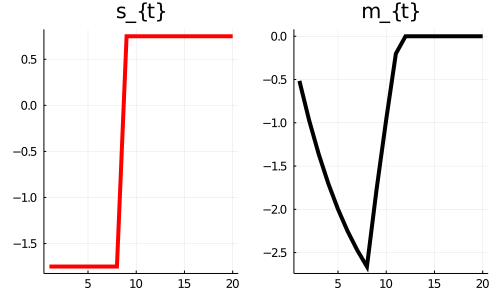

In [15]:
using Plots
using LaTeXStrings

Tshow = 20
plot(
    plot(Gs[Int.(svec[1:Tshow])],title="s_{t}",color=:red,legend=false),
    plot(mvec[1:Tshow],title="m_{t}",color=:black,legend=false),
    layout=(1,2),size=(500,300),linewidth=4)

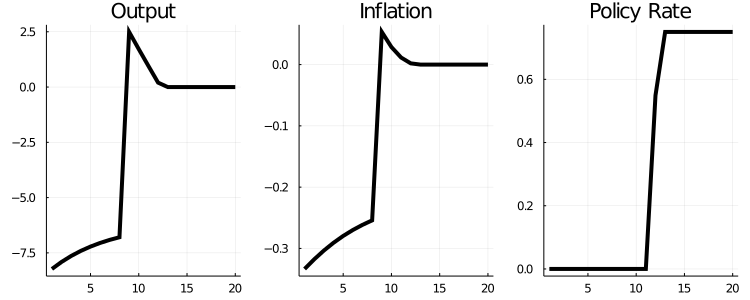

In [7]:
plot(
    plot(yvec[1:Tshow],title="Output",color=:black,legend=false),
    plot(pvec[1:Tshow],title="Inflation",color=:black,legend=false),
    plot(ivec[1:Tshow],title="Policy Rate",color=:black,legend=false),
    layout=(1,3),size=(750,300),linewidth=4)

(101,)
(101, 2)


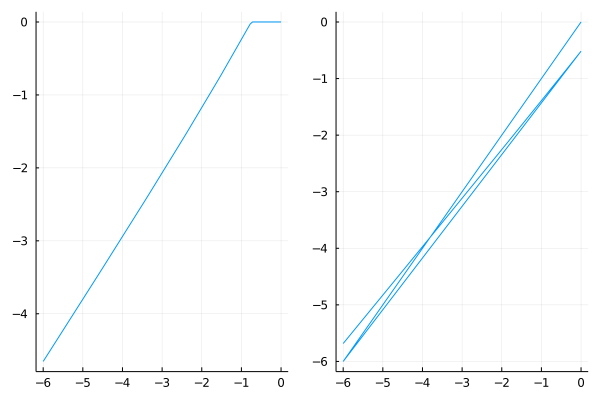

In [8]:
println(size(mgrid))
println(size(mmat0))

plot(
    plot(mgrid,mmat0[:,1],legend=false),
    plot([mgrid; mgrid],[mmat0[:,2]; mgrid],legend=false),
    layout=(1,2))